In [1]:
import gpytorch
import torch
from preprocessing.process_config import read_yaml
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
start_idx = 3000
nrows = 500
experiment_data = read_yaml(
        "configs/sawtell_for_GP.yaml", csv_type="sawtell", start_idx=start_idx, nrows=nrows
    )

Reading CSV...


In [3]:
data = experiment_data["points_2d_joints"]

In [4]:
print(data.shape)
print(experiment_data["config"]["bp_names"])
print(experiment_data["config"]["view_names"])
print(experiment_data["config"])

(3, 500, 2, 2)
['chin_base', 'head']
['top', 'main', 'right']
{'path_to_videos': ['/Volumes/sawtell-locker/C1/free/vids/20201218_Neil/concatenated.avi'], 'path_to_csv': ['/Volumes/sawtell-locker/C1/free/vids/20201218_Neil/concatenated_tracking.csv'], 'intrinsics': {'focal_length': {'focal_length_mm': 15, 'sensor_size': 12}}, 'extrinsics': {'translation': {'cam1': [0, -1.94, 1.72], 'cam2': [0, 0, 0], 'cam3': [1.86, 0, 1.72]}, 'rotation': {'cam1': ['-1/2', 0, 0], 'cam2': [0, 0, 0], 'cam3': [0, '-1/2', 0]}}, 'mirrored': True, 'filter_confidence_value': 0.0, 'image_limits': {'height_lims': [[0, 165], [165, -1], [165, -1]], 'width_lims': [[0, -1], [0, -1], [318, -1]]}, 'point_sizes': [3, 3, 3], 'bp_names': ['chin_base', 'head'], 'skeleton': [['chin_base', 'head']], 'color_list': ['red', 'blue'], 'view_names': ['top', 'main', 'right']}


In [5]:
assert(np.sum(np.isnan(data))==0)
dimension_names = ["views", "frames", "bodyparts", "coords"]

(500, 12)
['view: top, bodypart: chin_base, coord: x', 'view: top, bodypart: chin_base, coord: y', 'view: main, bodypart: chin_base, coord: x', 'view: main, bodypart: chin_base, coord: y', 'view: right, bodypart: chin_base, coord: x', 'view: right, bodypart: chin_base, coord: y', 'view: top, bodypart: head, coord: x', 'view: top, bodypart: head, coord: y', 'view: main, bodypart: head, coord: x', 'view: main, bodypart: head, coord: y', 'view: right, bodypart: head, coord: x', 'view: right, bodypart: head, coord: y']


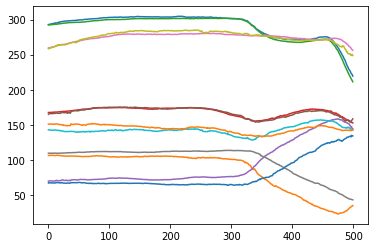

In [6]:
# specific reshaping -- can generalize
desired_shape = (data.shape[1], data.shape[0]*data.shape[2]*data.shape[3])
new_arr = np.zeros((desired_shape))
print(new_arr.shape)
coords = ["x", "y"]
counter = 0
name_list = []
for i in range(data.shape[2]):
    for j in range(data.shape[0]):
        for k in range(data.shape[3]): 
            #print(data[j, :, i, k].shape)
            new_arr[:,counter] = data[j, :, i, k]
            counter+=1
            name_list.append("view: {}, bodypart: {}, coord: {}".format( \
                experiment_data["config"]["view_names"][j], \
                    experiment_data["config"]["bp_names"][i], 
                     coords[k]))
for i in range(new_arr.shape[-1]):
    plt.plot(new_arr[:, i])
print(name_list)

In [7]:
# train_x = torch.linspace(0, 1, 1000)

# train_y = torch.stack([
#     torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
#     torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
# ], -1)
# print(train_x.shape)
# print(train_y.shape)

In [8]:
train_x = torch.linspace(0, 1, new_arr.shape[0]) # can match time more closely
train_y = torch.tensor(new_arr, dtype = torch.float)
print("train_x.shape: {}, train_y.shape: {}".format(train_x.shape, train_y.shape))
num_tasks = train_y.shape[-1]
rank = 5 # hardcoded for now
print("num_tasks: {}".format(num_tasks))

train_x.shape: torch.Size([500]), train_y.shape: torch.Size([500, 12])
num_tasks: 12


In [9]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks, rank):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)
model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks, rank)

In [10]:
training_iterations = 1000 # 2000?
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
with gpytorch.settings.max_cholesky_size(1e6):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

Iter 1/1000 - Loss: 46.222
Iter 2/1000 - Loss: 33.459
Iter 3/1000 - Loss: 25.472


KeyboardInterrupt: 

/Users/danbiderman/miniconda3/envs/3d-pose/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/danbiderman/miniconda3/envs/3d-pose/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/Users/danbiderman/miniconda3/envs/3d-pose/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical ins

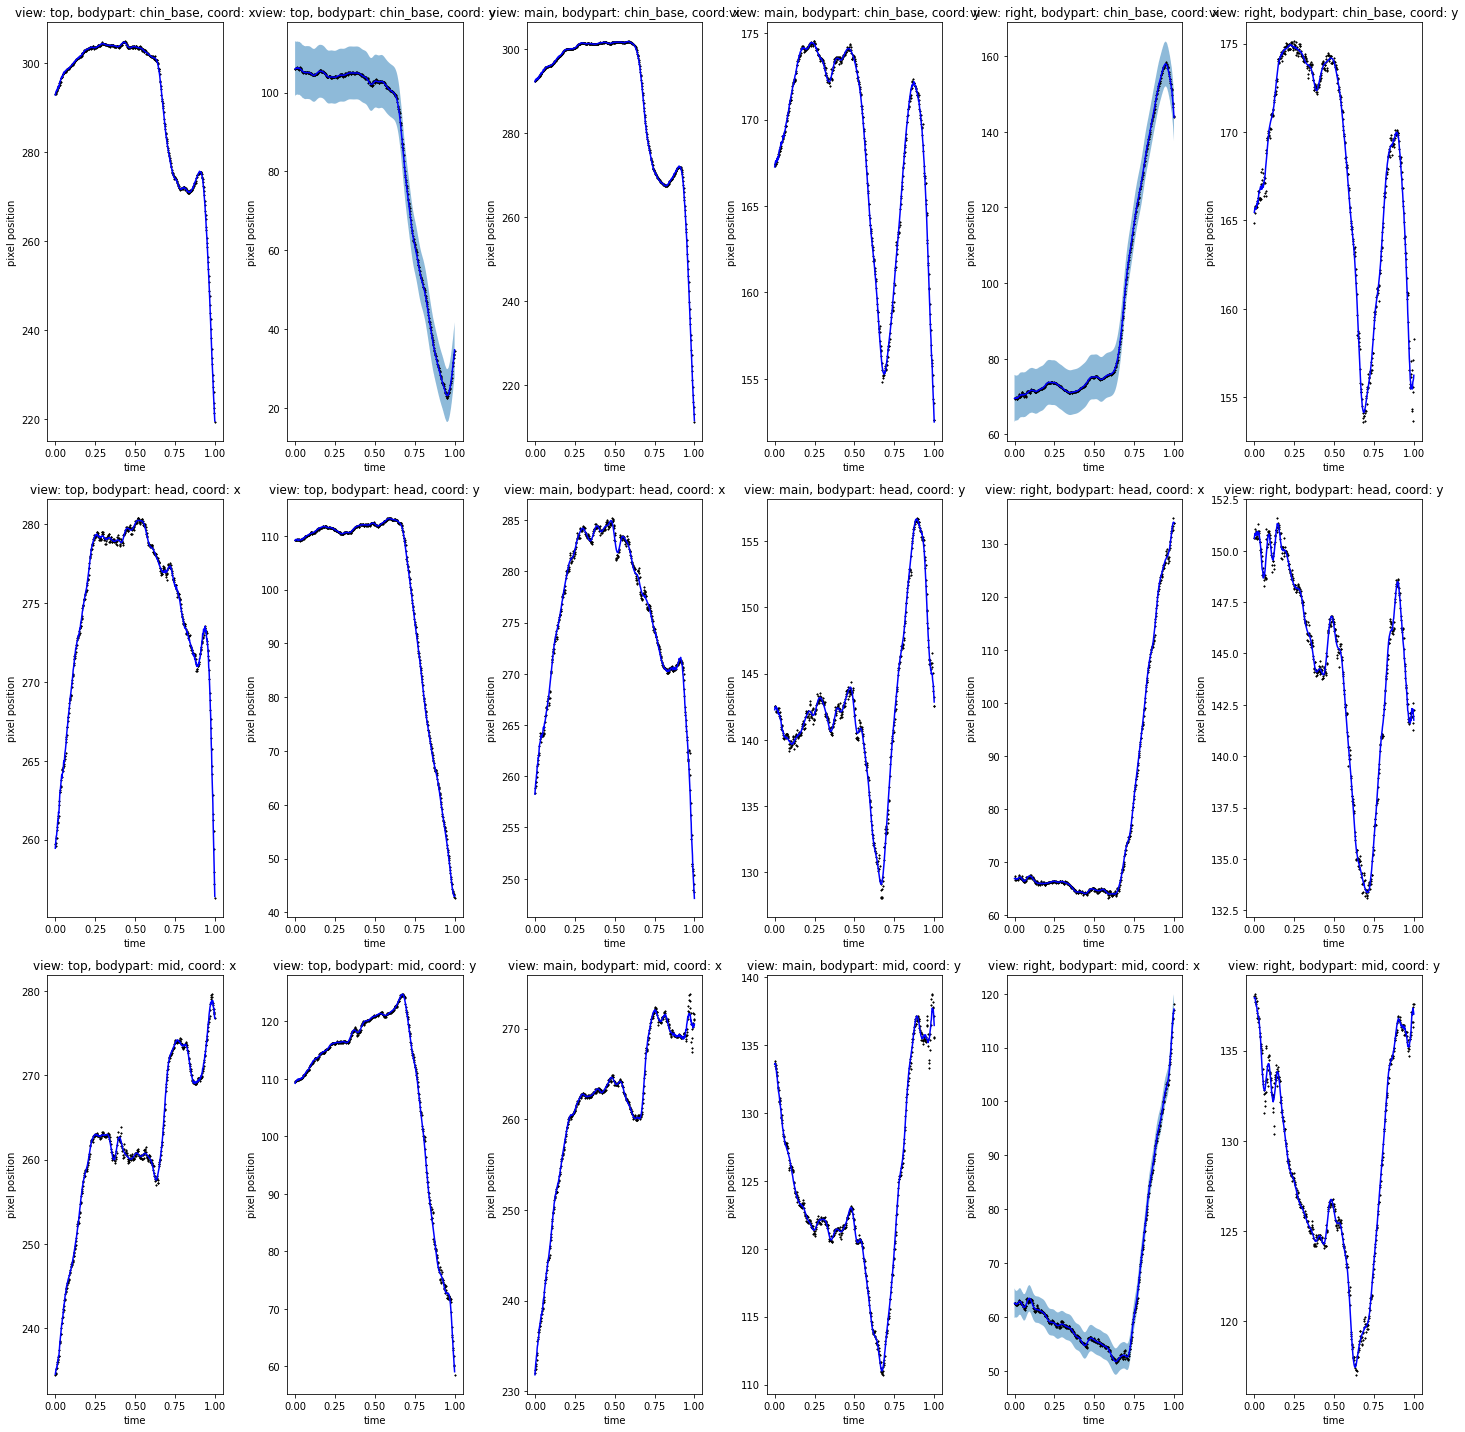

In [11]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
num_plot_rows = len(experiment_data["config"]["bp_names"])
fig, axs = plt.subplots(num_plot_rows, num_tasks//num_plot_rows, figsize=(20, 20))
axs = axs.flatten()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cholesky_size(1e6):
    test_x = torch.linspace(0, 1, new_arr.shape[0]) # used to be 51
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

for i, ax in enumerate(axs):
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, i].detach().numpy(), 'k*', markersize = 1.5)
# # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, i].numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower[:, i].numpy(), upper[:, i].numpy(), alpha=0.5)
    ax.set_title(name_list[i])
    ax.set_xlabel("time")
    ax.set_ylabel("pixel position")
fig.tight_layout()
plt.savefig("GP/figs/initial_pred.png")
# y1_ax.set_ylim([-3, 3])
# y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
# y1_ax.set_title('Observed Values (Likelihood)')

# # Plot training data as black stars
# y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# # Predictive mean as blue line
# y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# # Shade in confidence
# y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
# y2_ax.set_ylim([-3, 3])
# y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
# y2_ax.set_title('Observed Values (Likelihood)')

In [12]:
# # Make predictions
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_x = torch.linspace(0, 1, new_arr.shape[0]) # used to be 51
#     predictions = likelihood(model(test_x))
#     mean = predictions.mean
#     lower, upper = predictions.confidence_region()
pred_mean = mean.numpy()
print(pred_mean.shape)

(500, 18)


['view: top, bodypart: chin_base, coord: x', 'view: top, bodypart: chin_base, coord: y', 'view: main, bodypart: chin_base, coord: x', 'view: main, bodypart: chin_base, coord: y', 'view: right, bodypart: chin_base, coord: x', 'view: right, bodypart: chin_base, coord: y', 'view: top, bodypart: head, coord: x', 'view: top, bodypart: head, coord: y', 'view: main, bodypart: head, coord: x', 'view: main, bodypart: head, coord: y', 'view: right, bodypart: head, coord: x', 'view: right, bodypart: head, coord: y', 'view: top, bodypart: mid, coord: x', 'view: top, bodypart: mid, coord: y', 'view: main, bodypart: mid, coord: x', 'view: main, bodypart: mid, coord: y', 'view: right, bodypart: mid, coord: x', 'view: right, bodypart: mid, coord: y']


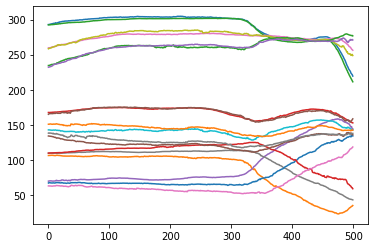

In [13]:
counter = 0
name_list = []
data_reverted = np.zeros_like(data)
pred_mean_reverted = np.zeros_like(data)
for i in range(data.shape[2]): # bps
    for j in range(data.shape[0]): # views
        for k in range(data.shape[3]): # coords
            new_arr[:,counter] = data[j, :, i, k]
            data_reverted[j, :, i, k] = new_arr[:, counter] # just undoing the operation to convert predictions to write format
            pred_mean_reverted[j, :, i, k] = pred_mean[:, counter]
            counter+=1
            name_list.append("view: {}, bodypart: {}, coord: {}".format( \
                experiment_data["config"]["view_names"][j], \
                    experiment_data["config"]["bp_names"][i], 
                     coords[k]))
for i in range(new_arr.shape[-1]):
    plt.plot(new_arr[:, i])
print(name_list)

In [14]:
from reconstruct_points import extract_frames, cut_frames, save_reproj, write_video, get_F_geometry

In [15]:
experiment_data["config"]["path_to_videos"]

['/Volumes/sawtell-locker/C1/free/vids/20201218_Neil/concatenated.avi']

In [16]:
frames = extract_frames(indices = np.arange(start_idx, start_idx+nrows), 
                        video_path= experiment_data["config"]["path_to_videos"][0])
og_dims = frames[0].shape
frames = cut_frames(frames, experiment_data["img_settings"])

In [17]:
reproj_frames = save_reproj(
    points_2d_reproj = pred_mean_reverted,
    points_2d_og = data,
    cam_group = experiment_data["cam_group"],
    point_sizes = experiment_data["config"]["point_sizes"],
    F = get_F_geometry(experiment_data["cam_group"]),
    color_list = experiment_data["config"]["color_list"],
    path_images = frames,
    plot_dir = "GP/ims",
    og_dims=og_dims,
    img_settings=experiment_data["img_settings"],
    config=experiment_data["config"],
    write_frames=True,
)

100%|██████████| 500/500 [00:08<00:00, 62.13it/s] 


In [18]:
write_video(
        frames=reproj_frames,
        out_file="GP/vids/predictions.mov",
        fps=50,
        add_text=True,
    )

In [85]:
reshaped_data = np.zeros_like(data)
print(reshaped_data.shape)

(3, 500, 2, 2)


In [87]:
for i in range(3):
    reshaped_data[i,:,0,:] = new_arr[:, i*2: i*2 + 2]

In [89]:
assert (data_reverted == data).all()